<a href="https://colab.research.google.com/github/Soniazdp/HybridRecommender/blob/sherry/exp_gnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install dgl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 61.5 MB/s eta 0:00:00


## Data Preparation

Import the required libraries, and load edge list data into a graph object.

In [3]:
import torch
import torch.nn as nn

import numpy as np
import scipy.sparse as sp
import torch.nn.functional as F

import dgl
from dgl.nn import SAGEConv
import dgl.function as fn
from sklearn.metrics import roc_auc_score
import itertools

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


In [4]:
# import necessary libraries
import spacy
import en_core_web_sm
import gensim.downloader as api

# load pre-trained models
nlp = en_core_web_sm.load()
model_2 = api.load('glove-twitter-25')

# define hashtags
# hashtags = ['#applepieisdelicious', '#harrypotterandthephilosophersstone', '#thisisareallylonghashtagwithlotsofwords']



# apply function to each hashtag
# for hashtag in hashtags:
#     avg_vector = segment_hashtag(hashtag)
#     print(f"Hashtag: {hashtag}\nAverage vector: {avg_vector}\n")


[==================================================] 100.0% 104.8/104.8MB downloaded


In [5]:
# define function to segment hashtags
def segment_hashtag(hashtag):
    # define a dictionary of words
    words = list(model_2.key_to_index.keys())

    # split hashtag into words using Maximum Matching algorithm
    segments = []
    while hashtag:
        for i in range(len(hashtag), 0, -1):
            if hashtag[:i] in words:
                segments.append(hashtag[:i])
                hashtag = hashtag[i:]
                break
        else:
            segments.append(hashtag[0])
            hashtag = hashtag[1:]

    # get vector for each word
    vectors = [model_2.get_vector(word) if word in model_2.key_to_index else [0]*25 for word in segments]  # use a zero vector if word is not in model

    # compute average of word vectors
    avg_vector = [sum(vec[i] for vec in vectors) / len(vectors) for i in range(len(vectors[0]))]
    
    return avg_vector

In [6]:
with open('/content/edge-all.csv', 'r') as f:
    edges = f.readlines()

edges = [edge.strip().split(',') for edge in edges]
categories = edges[0] #['Source', 'Source_name', 'Target', 'Target_name', 'Type', 'Id', 'Label', 'Weight']

# identify source and target nodes and make them tensors
u = torch.tensor([int(edge[0]) for edge in edges[1:]])
v = torch.tensor([int(edge[2]) for edge in edges[1:]])
u_name = [edge[1] for edge in edges[1:]]
v_name = [edge[3] for edge in edges[1:]]
g = dgl.graph((u, v))
#g = dgl.to_bidirected(g) # make the graph bidirectional


In [ ]:
# load features
with open('/content/node-all.csv', 'r', encoding="utf-8") as f:
    name = f.readlines()
name = [c.strip().split(',') for c in name][1:]
name = {c[1][1:]: c[1] for c in name}
name_to_vec = {}
for key in name:
  name[key] = segment_hashtag(name[key])
  print("find", key)

In [8]:
# create a tensor of count values based on the given node IDs
name_vec = []
for i in range(len(u)):
    name_vec.append((int(u[i]), u_name[i], tuple(name[u_name[i][1:]])))
for i in range(len(v)):
    name_vec.append((int(v[i]), v_name[i], tuple(name[v_name[i][1:]])))
name_vec = sorted(list(set(name_vec)))

In [9]:
node_names = [''] + [c[1] for c in name_vec]
name_tensor = torch.tensor([list(c[2]) for c in name_vec])
name_tensor = name_tensor.squeeze()
# create null tensor of same shape
null_tensor = torch.zeros_like(name_tensor[0]).unsqueeze(0)
# concatenate null tensor with original tensor
new_tensor = torch.cat([null_tensor, name_tensor], dim=0)
name_tensor = new_tensor.unsqueeze(1)
g.ndata['feat'] = new_tensor

In [159]:
g

Graph(num_nodes=150, num_edges=3024,
      ndata_schemes={'feat': Scheme(shape=(25,), dtype=torch.float64)}
      edata_schemes={})

## Prepare training, validation and test data
We split the dataset into the three sets with the ratio of 0.70, 0.15 and 0.15 with random sampling.

In [10]:
eids = np.arange(g.number_of_edges())
eids = np.random.permutation(eids)

# split into train, val, test
test_size = val_size = int(len(eids) * 0.15)
train_size = len(eids) - val_size - test_size

test_pos_u, test_pos_v = u[eids[:test_size]], v[eids[:test_size]]
val_pos_u, val_pos_v = u[eids[test_size:test_size+val_size]], v[eids[test_size:test_size+val_size]]
train_pos_u, train_pos_v = u[eids[test_size+val_size:]], v[eids[test_size+val_size:]]

# find negative edges by randomly sampling from all possible edges.
# change shape to num_nodes of graph
adj = sp.coo_matrix((np.ones(len(u)), (u.numpy(), v.numpy())), shape=(150, 150)) #(150, 150) for < 80
adj_neg = 1 - adj.todense() - np.eye(g.number_of_nodes())
neg_u, neg_v = np.where(adj_neg != 0)

neg_eids = np.random.choice(len(neg_u), len(eids))
test_neg_u, test_neg_v = neg_u[neg_eids[:test_size]], neg_v[neg_eids[:test_size]]
val_neg_u, val_neg_v = neg_u[neg_eids[test_size:test_size+val_size]], neg_v[neg_eids[test_size:test_size+val_size]]
train_neg_u, train_neg_v = neg_u[neg_eids[test_size+val_size:]], neg_v[neg_eids[test_size+val_size:]]

When training, we need to remove the edges in the test set from the original graph via `dgl.remove_edges`. 

In [11]:
train_g = dgl.remove_edges(g, eids[:test_size])

## Define the model

The model consists of two GraphSAGE layers, each computes new node representations by averaging neighbor information. DGL provides ``dgl.nn.SAGEConv`` that conveniently creates a GraphSAGE layer.

In [12]:
# build a two-layer GraphSAGE model
class GraphSAGE(nn.Module):
    def __init__(self, in_feats, h_feats):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_feats, h_feats, 'mean')
        self.conv2 = SAGEConv(h_feats, h_feats, 'mean')
    
    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.sigmoid(h)
        h = self.conv2(g, h)

        return h

## Create positive and negative edges for training

-  Treat the edges in the graph as *positive examples*.
-  Sample a number of non-existent edges (i.e. node pairs with no edges
   between them) as *negative* examples.
-  Divide the positive examples and negative examples into a training, validation and test set.

In [13]:
# Note: num_nodes was g.number_of_nodes() in the original code
train_pos_g = dgl.graph((train_pos_u, train_pos_v), num_nodes=g.number_of_nodes())
train_neg_g = dgl.graph((train_neg_u, train_neg_v), num_nodes=g.number_of_nodes())

test_pos_g = dgl.graph((test_pos_u, test_pos_v), num_nodes=g.number_of_nodes())
test_neg_g = dgl.graph((test_neg_u, test_neg_v), num_nodes=g.number_of_nodes())

In [14]:
test_pos_g

Graph(num_nodes=150, num_edges=277,
      ndata_schemes={}
      edata_schemes={})

The following code computes new edge features based on the incident nodes' features and the original edge features (if applicable) via `DGLGraph.apply_edges`.

DGL provides a set of optimized builtin functions to compute new
edge features based on the original node/edge features. For example,
``dgl.function.u_dot_v`` computes a dot product of the incident nodes’
representations for each edge.

In [15]:
class DotPredictor(nn.Module):
    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            # Compute a new edge feature named 'score' by a dot-product between the
            # source node feature 'h' and destination node feature 'h'.
            g.apply_edges(fn.u_dot_v('h', 'h', 'score'))
            # u_dot_v returns a 1-element vector for each edge so you need to squeeze it.
            return g.edata['score'][:, 0]

## Training loop

After defining the node representation and edge score computation, the training loop can thus be defined. The evaluation metric is the area under the ROC curve (AUC).

In [16]:
model = GraphSAGE(train_g.ndata['feat'].shape[1], 16)
# You can replace DotPredictor with MLPPredictor.
#pred = MLPPredictor(16)
pred = DotPredictor()

def compute_loss(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])])
    return F.binary_cross_entropy_with_logits(scores, labels)

def compute_auc(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score]).numpy()
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).numpy()
    return roc_auc_score(labels, scores)

In [17]:
optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)
all_logits = []
l = []
epoch = 30
for e in range(epoch):
    # forward
    h = model(train_g, train_g.ndata['feat'].float())
    pos_score = pred(train_pos_g, h)
    neg_score = pred(train_neg_g, h)
    loss = compute_loss(pos_score, neg_score)
    l.append(loss.item())
    
    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if e % 5 == 0:
        print('In epoch {}, loss: {}'.format(e, loss))

/usr/local/lib/python3.9/dist-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


In epoch 0, loss: 12.159568786621094
In epoch 5, loss: 1.2714320421218872
In epoch 10, loss: 0.9298271536827087
In epoch 15, loss: 0.8359984755516052
In epoch 20, loss: 0.7466654181480408
In epoch 25, loss: 0.7092294692993164


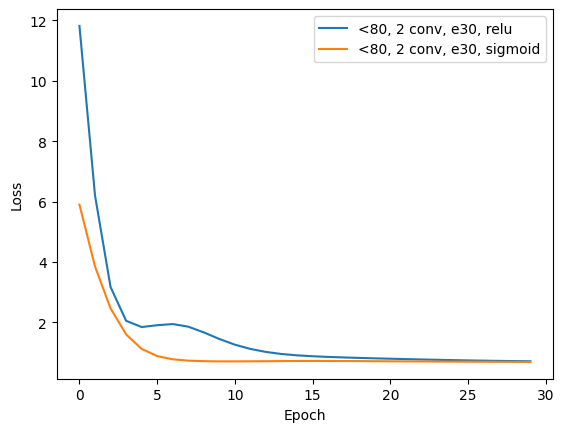

In [221]:
fig, ax = plt.subplots()

ax.plot(np.arange(len(losses[1])), losses[1], label=label[1])
ax.plot(np.arange(len(losses[6])), losses[6], label=label[6])

ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots()
for i, loss in enumerate(losses):
    if i != 6 or i != 1:
      continue
    ax.plot(np.arange(len(loss)), loss, label=label[i])

ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()
plt.show()

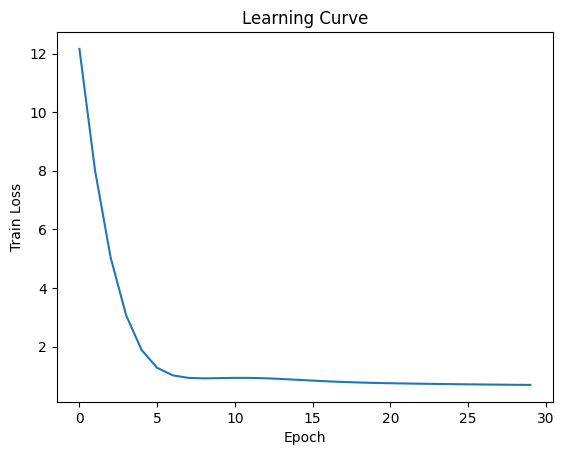

In [18]:
import matplotlib.pyplot as plt

plt.plot(np.arange(epoch), np.asarray(l))
plt.title("Learning Curve")
plt.xlabel("Epoch")
plt.ylabel("Train Loss")
plt.show()

In [19]:
with torch.no_grad():
    pos_score = pred(test_pos_g, h)
    neg_score = pred(test_neg_g, h)
    print('AUC', compute_auc(pos_score, neg_score))

AUC 0.6813916511358157


/usr/local/lib/python3.9/dist-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


## Predict top 10 connections

In [30]:
p = pred(test_neg_g, h)

In [52]:
# find the indices of the top 2 edges
topk_indices = torch.topk(p, k=10).indices

# get the nodes corresponding to the top 2 edges
src_nodes = test_neg_g.nodes()[g.edges()[0][topk_indices]]
dst_nodes = test_neg_g.nodes()[g.edges()[1][topk_indices]]

print("Source nodes of top-k edges: ", src_nodes)
print("Destination nodes of top-k edges: ", dst_nodes)

Source nodes of top-k edges:  tensor([5, 1, 2, 4, 3, 7, 3, 6, 8, 9])
Destination nodes of top-k edges:  tensor([11, 15, 17, 18, 22, 18, 24, 22, 10, 60])


In [62]:
src = src_nodes.cpu().numpy()
dst = dst_nodes.cpu().numpy()
s, d = test_neg_u[src], test_neg_v[dst]
print('top 10 connections')
for i in range(10):
  u = name_vec[s[i]][1]
  v = name_vec[d[i]][1]
  print(u, v)

top 10 connections
#rashford #wildcats
#retouch #designerbrasileiro
#socceredit #london
#premierleague #sportsdesign
#kstate #rashford
#photoshop #sportsdesign
#kstate #gauchao
#oldtrafford #rashford
#footballgraphic #eliteeight
#footyheadlines #HomeDecor
